In [1]:
import re
import os
import pandas as pd

regex = re.compile(r'\[.+\]\n', re.IGNORECASE)
file_paths, file_names, emotions, audios = [], [], [], []
emotion_map = {'Neutral': 'neutral', 'Anger': 'angry', 'Happiness': 'happy', 'Sadness': 'sad', 'Fear': 'fear',
              'Disgust': 'disgust'}

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1
0.12.1+cu113
cuda


In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE
extractor = bundle.get_model()
print(extractor.__class__)
print(bundle.sample_rate)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>
16000


In [4]:
# Define path to datasets
DATA_NATURAL = "/home/rl3155/MESD_All"
entries = os.listdir(DATA_NATURAL)

from tqdm import tqdm

for i in tqdm(range(len(entries))):
    entry = entries[i]
    path = DATA_NATURAL + "/" + entry
    if "wav" not in path:
        continue
    emotion = emotion_map[entry.split("_")[0]]
    
    file_paths.append(path)
    file_names.append(entry)
    emotions.append(emotion)
    
    wave, sr = torchaudio.load(path)
    if sr != bundle.sample_rate:
        wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
        feature, _ = extractor.extract_features(wave)
    feature = [f[0] for f in feature]
    audio = torch.stack(feature)
    audios.append(audio)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 863/863 [02:08<00:00,  6.73it/s]


In [5]:
file = pd.DataFrame({'path':file_paths, 'name': file_names, 'emotion': emotions, 'audio': audios})

In [6]:
file.head()

,path,name,emotion,audio
0,/home/rl3155/MESD_All/Anger_C_B_delincuencia.wav,Anger_C_B_delincuencia.wav,angry,"[[[tensor(0.0150), tensor(-0.1221), tensor(-0...."
1,/home/rl3155/MESD_All/Happiness_M_A_hoy.wav,Happiness_M_A_hoy.wav,happy,"[[[tensor(0.1759), tensor(0.0419), tensor(-0.2..."
2,/home/rl3155/MESD_All/Disgust_C_B_irrespetuoso...,Disgust_C_B_irrespetuoso.wav,disgust,"[[[tensor(0.1175), tensor(0.0788), tensor(0.09..."
3,/home/rl3155/MESD_All/Sadness_M_B_hambre.wav,Sadness_M_B_hambre.wav,sad,"[[[tensor(-0.0332), tensor(-0.1192), tensor(-0..."
4,/home/rl3155/MESD_All/Neutral_F_A_izquierda.wav,Neutral_F_A_izquierda.wav,neutral,"[[[tensor(0.0090), tensor(0.1068), tensor(-0.0..."


In [9]:
main_path = '/home/rl3155/Multilingual-Speech-Emotion-Recognition-System/Spanish/Spanish_New'
dataframe_path = main_path + '/wavs/wav2vecbase_mean.csv'

file.to_csv(dataframe_path)

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

saudios, semotions = shuffle(audios, emotions, random_state=42)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(saudios, semotions, test_size=0.2, random_state=1)

In [10]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, audios, labels, label_transform):
        super(MyDataSet).__init__()
        self.audios = audios
        self.labels = labels
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        label = self.label_transform[self.labels[idx]]
        audio = self.audios[idx]
        length = audio.size(1)
        return audio, length, label
    
    def __len__(self):
        return len(self.labels)

In [11]:
def collate_indic(data):
    audios, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = audios[0].size(2)
    n_dims = audios[0].size(0)
    features = torch.zeros((len(audios), n_dims, max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = audios[i].size(1), audios[i].size(2)
        features[i] = torch.cat([audios[i], torch.zeros((n_dims, max_len - j, k))], dim=1)

    return features, lengths, labels

In [12]:
categories = ['neutral', 'angry', 'happy', 'sad', 'fear', 'disgust']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'neutral': 0, 'angry': 1, 'happy': 2, 'sad': 3, 'fear': 4, 'disgust': 5}

In [13]:
from torch.utils.data import DataLoader

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=16, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, 
                              collate_fn=collate_indic)

test_dataset = MyDataSet(X_val, y_val, cate_dic)
testloader_args = dict(batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, 
                             collate_fn=collate_indic)

## Train with 3CNN+LSTM

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, dims = 12, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.aggr = nn.Conv1d(in_channels=dims, out_channels=1, kernel_size=1)
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """
        n, d, b, t = x.size(0), x.size(1), x.size(2), x.size(3)
        x = torch.flatten(x, start_dim=2)
        input = self.aggr(x)
        input = torch.reshape(input, (n, b, t))
        input = self.embed(input)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

### Model Traning on each layer 

In [15]:
from tqdm import tqdm
from torchsummary import summary
import torch.optim as optim

model = ICASSP3CNN(768)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 50
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f},", 
          f"train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f},", 
          f"valid loss:{valid_loss:.2f}")

  2%|████                                                                                                                                                                                                         | 1/50 [00:09<08:02,  9.85s/it]

epoch:1, train accu:0.1858, train loss:1.87, valid accu:0.2428, valid loss:1.82


  4%|████████▏                                                                                                                                                                                                    | 2/50 [00:11<04:11,  5.24s/it]

epoch:2, train accu:0.1771, train loss:1.80, valid accu:0.3121, valid loss:1.57


  6%|████████████▎                                                                                                                                                                                                | 3/50 [00:13<02:55,  3.74s/it]

epoch:3, train accu:0.2424, train loss:1.67, valid accu:0.2890, valid loss:1.50


  8%|████████████████▍                                                                                                                                                                                            | 4/50 [00:15<02:18,  3.02s/it]

epoch:4, train accu:0.3062, train loss:1.56, valid accu:0.3757, valid loss:1.33


 10%|████████████████████▌                                                                                                                                                                                        | 5/50 [00:17<01:58,  2.63s/it]

epoch:5, train accu:0.3498, train loss:1.37, valid accu:0.3295, valid loss:1.49


 12%|████████████████████████▌                                                                                                                                                                                    | 6/50 [00:19<01:45,  2.40s/it]

epoch:6, train accu:0.3788, train loss:1.34, valid accu:0.4162, valid loss:1.17


 14%|████████████████████████████▋                                                                                                                                                                                | 7/50 [00:21<01:35,  2.23s/it]

epoch:7, train accu:0.4848, train loss:1.11, valid accu:0.3468, valid loss:1.43


 16%|████████████████████████████████▊                                                                                                                                                                            | 8/50 [00:23<01:29,  2.13s/it]

epoch:8, train accu:0.4194, train loss:1.23, valid accu:0.4162, valid loss:1.19


 18%|████████████████████████████████████▉                                                                                                                                                                        | 9/50 [00:25<01:25,  2.08s/it]

epoch:9, train accu:0.4920, train loss:1.02, valid accu:0.4393, valid loss:1.09


 20%|████████████████████████████████████████▊                                                                                                                                                                   | 10/50 [00:27<01:21,  2.04s/it]

epoch:10, train accu:0.5559, train loss:0.90, valid accu:0.5202, valid loss:1.10


 22%|████████████████████████████████████████████▉                                                                                                                                                               | 11/50 [00:29<01:18,  2.01s/it]

epoch:11, train accu:0.5414, train loss:0.98, valid accu:0.5549, valid loss:1.10


 24%|████████████████████████████████████████████████▉                                                                                                                                                           | 12/50 [00:31<01:23,  2.20s/it]

epoch:12, train accu:0.5922, train loss:0.87, valid accu:0.4971, valid loss:1.03


 26%|█████████████████████████████████████████████████████                                                                                                                                                       | 13/50 [00:33<01:18,  2.13s/it]

epoch:13, train accu:0.6009, train loss:0.82, valid accu:0.5549, valid loss:0.96


 28%|█████████████████████████████████████████████████████████                                                                                                                                                   | 14/50 [00:35<01:14,  2.07s/it]

epoch:14, train accu:0.6749, train loss:0.84, valid accu:0.5954, valid loss:0.93


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                              | 15/50 [00:37<01:10,  2.03s/it]

epoch:15, train accu:0.7141, train loss:0.68, valid accu:0.6069, valid loss:0.92


 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                          | 16/50 [00:39<01:07,  2.00s/it]

epoch:16, train accu:0.7242, train loss:0.62, valid accu:0.6879, valid loss:0.79


 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 17/50 [00:41<01:05,  1.98s/it]

epoch:17, train accu:0.6938, train loss:0.67, valid accu:0.6416, valid loss:0.88


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 18/50 [00:43<01:02,  1.96s/it]

epoch:18, train accu:0.7605, train loss:0.58, valid accu:0.6474, valid loss:0.89


 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 19/50 [00:45<01:00,  1.95s/it]

epoch:19, train accu:0.7968, train loss:0.47, valid accu:0.6474, valid loss:0.88


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 20/50 [00:47<00:58,  1.95s/it]

epoch:20, train accu:0.8142, train loss:0.50, valid accu:0.6069, valid loss:1.20


 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 21/50 [00:49<00:56,  1.96s/it]

epoch:21, train accu:0.8331, train loss:0.49, valid accu:0.6763, valid loss:0.88


 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 22/50 [00:51<00:54,  1.96s/it]

epoch:22, train accu:0.8766, train loss:0.34, valid accu:0.7168, valid loss:0.83


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 23/50 [00:53<00:53,  1.97s/it]

epoch:23, train accu:0.9115, train loss:0.26, valid accu:0.5838, valid loss:1.30


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 24/50 [00:55<00:50,  1.96s/it]

epoch:24, train accu:0.9071, train loss:0.27, valid accu:0.7225, valid loss:0.85


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 25/50 [00:57<00:48,  1.96s/it]

epoch:25, train accu:0.9376, train loss:0.25, valid accu:0.6127, valid loss:1.18


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 26/50 [00:59<00:46,  1.95s/it]

epoch:26, train accu:0.9231, train loss:0.22, valid accu:0.7052, valid loss:1.01


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 27/50 [01:01<00:44,  1.95s/it]

epoch:27, train accu:0.9594, train loss:0.18, valid accu:0.6358, valid loss:1.09


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 28/50 [01:03<00:43,  1.96s/it]

epoch:28, train accu:0.8766, train loss:0.36, valid accu:0.6821, valid loss:1.04


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 29/50 [01:05<00:40,  1.95s/it]

epoch:29, train accu:0.9376, train loss:0.22, valid accu:0.7572, valid loss:0.81


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 30/50 [01:06<00:38,  1.94s/it]

epoch:30, train accu:0.9536, train loss:0.21, valid accu:0.6994, valid loss:0.86


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 31/50 [01:08<00:36,  1.94s/it]

epoch:31, train accu:0.8621, train loss:0.41, valid accu:0.6590, valid loss:1.18


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 32/50 [01:10<00:35,  1.95s/it]

epoch:32, train accu:0.8926, train loss:0.31, valid accu:0.6763, valid loss:0.96


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 33/50 [01:12<00:33,  1.94s/it]

epoch:33, train accu:0.9361, train loss:0.29, valid accu:0.7283, valid loss:0.92


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 34/50 [01:14<00:30,  1.93s/it]

epoch:34, train accu:0.8999, train loss:0.29, valid accu:0.6936, valid loss:1.05


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 35/50 [01:16<00:28,  1.93s/it]

epoch:35, train accu:0.9710, train loss:0.21, valid accu:0.6647, valid loss:1.21


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 36/50 [01:18<00:27,  1.93s/it]

epoch:36, train accu:0.7881, train loss:0.66, valid accu:0.7168, valid loss:0.85


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 37/50 [01:20<00:25,  1.93s/it]

epoch:37, train accu:0.8795, train loss:0.31, valid accu:0.7110, valid loss:0.88


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 38/50 [01:22<00:23,  1.93s/it]

epoch:38, train accu:0.9565, train loss:0.16, valid accu:0.7457, valid loss:0.91


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 39/50 [01:24<00:21,  1.93s/it]

epoch:39, train accu:0.9681, train loss:0.10, valid accu:0.7341, valid loss:0.90


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 40/50 [01:26<00:19,  1.93s/it]

epoch:40, train accu:0.9797, train loss:0.06, valid accu:0.7399, valid loss:0.85


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 41/50 [01:28<00:17,  1.93s/it]

epoch:41, train accu:0.9898, train loss:0.05, valid accu:0.6936, valid loss:1.14


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 42/50 [01:30<00:16,  2.05s/it]

epoch:42, train accu:0.9753, train loss:0.08, valid accu:0.7630, valid loss:0.87


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 43/50 [01:32<00:14,  2.13s/it]

epoch:43, train accu:0.9884, train loss:0.05, valid accu:0.7572, valid loss:0.89


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 44/50 [01:34<00:12,  2.09s/it]

epoch:44, train accu:0.9913, train loss:0.06, valid accu:0.7861, valid loss:0.89


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 45/50 [01:36<00:10,  2.05s/it]

epoch:45, train accu:0.9158, train loss:0.29, valid accu:0.7168, valid loss:1.00


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/50 [01:38<00:08,  2.04s/it]

epoch:46, train accu:0.9478, train loss:0.14, valid accu:0.7283, valid loss:0.94


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 47/50 [01:40<00:05,  1.99s/it]

epoch:47, train accu:0.9797, train loss:0.10, valid accu:0.6936, valid loss:1.12


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 48/50 [01:42<00:03,  1.95s/it]

epoch:48, train accu:0.8679, train loss:0.39, valid accu:0.7746, valid loss:0.79


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 49/50 [01:44<00:01,  1.92s/it]

epoch:49, train accu:0.9695, train loss:0.16, valid accu:0.7746, valid loss:0.74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.13s/it]

epoch:50, train accu:0.8853, train loss:0.34, valid accu:0.7283, valid loss:0.94


In [18]:
model_path = main_path + '/models/wav2vecbase.pth'

torch.save({'epoch':epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path)

metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 
                         'valid loss':valid_losses, 'train accu':train_accuracies, 
                         'valid_accu':valid_accuracies})
metadata_path = main_path + '/results/acc_loss/wav2vecbase.csv'
metadata.to_csv(metadata_path, index=False)

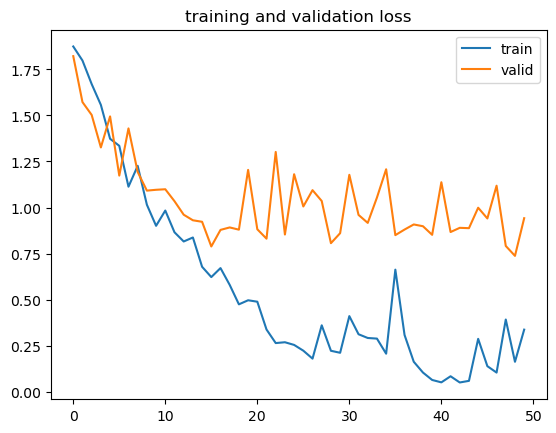

In [16]:

import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()
     

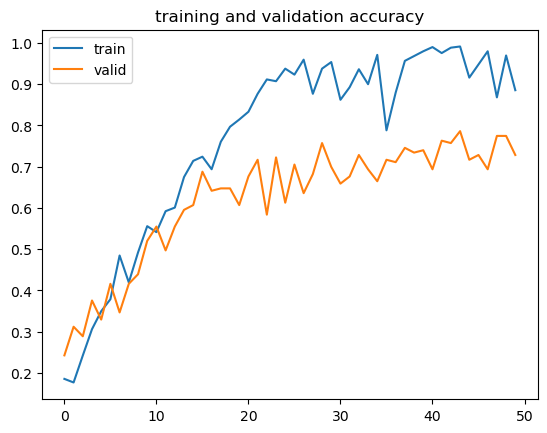

In [17]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

for inputs, lengths, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs, lengths) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

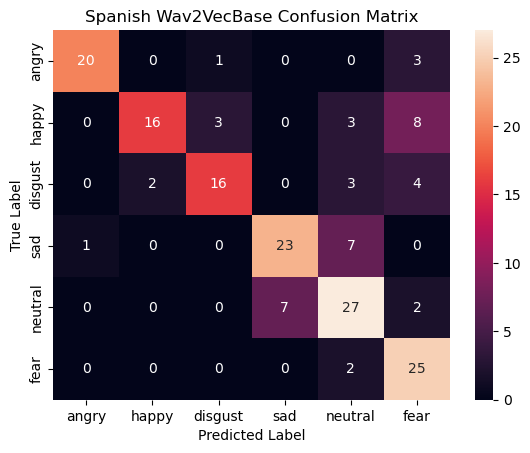

In [25]:
import numpy as np
import seaborn as sns

cf = confusion_matrix(y_true, y_pred)
classes = list(file['emotion'].unique())
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                     columns = [i for i in classes])
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Spanish Wav2VecBase Confusion Matrix')
fig_path = main_path + '/results/confusion_matrix/wav2vecbase.png'
plt.savefig(fig_path)